In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import torch.optim as optim
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
## Tensors from images - Custom dataset
import glob

class DatasetFromImages(Dataset):
    def __init__(self, file_pattern):
        self.files_list = glob.glob(file_pattern)
    
    def __len__(self):
        return len(self.files_list)
    
    def __getitem__(self, idx):
        file_path = self.files_list[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        tensor = transform(image)
        return tensor

In [262]:
## Make dataset

batch_size = 10
images_dataset = DatasetFromImages('data/SRK_TC/*/*')
images_dataloader = torch.utils.data.DataLoader(images_dataset, batch_size=batch_size, 
                                                   shuffle=True)

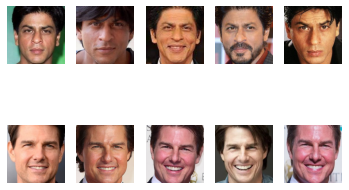

In [263]:
fig, axs = plt.subplots(2, 5)
for idx, image in enumerate(images_dataset):
#     print(image.shape)
    axs[idx//5, idx%5].axis('off')
    axs[idx//5, idx%5].imshow(image.squeeze().permute(1,2,0))

In [265]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 'same')
        self.conv2 = nn.Conv2d(6, 12, 3, padding = 'same')
        self.conv3 = nn.Conv2d(12, 24, 3, padding = 'same')
        self.fc1 = nn.Linear(24 * 25 * 25, 120)
        self.fc2 = nn.Linear(120, 10)
        self.fc3 = nn.Linear(10, 1)
        

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), 2)
        x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        x = F.avg_pool2d(F.relu(self.conv3(x)), 2)
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 120)
        self.fc3 = nn.Linear(120, 24 * 25 * 25)
        
        self.conv2 = nn.Conv2d(24, 12, 3, padding = 'same')
        self.conv3 = nn.Conv2d(12, 6, 3, padding = 'same')
        self.conv4 = nn.Conv2d(6, 3, 3, padding = 'same')

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = x.reshape((-1, 24, 25, 25))
        
        x = F.interpolate(x, scale_factor = (2, 2))
        x = F.relu(self.conv2(x))
        x = F.interpolate(x, scale_factor = (2, 2))
        x = F.relu(self.conv3(x))
        x = F.interpolate(x, scale_factor = (2, 2))
        x = self.conv4(x)
        
        return x

class CompressNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [266]:
x = orig = images_dataset[0].unsqueeze(0)
x = Encoder()(x)
print('Compression ratio = ', orig.flatten().shape[0] / x.flatten().shape[0])

Compression ratio =  120000.0


In [267]:
net = CompressNet()
net = nn.DataParallel(net)
net.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [300]:
summary(net, (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 200, 200]             168
            Conv2d-2          [-1, 6, 200, 200]             168
            Conv2d-3         [-1, 12, 100, 100]             660
            Conv2d-4         [-1, 12, 100, 100]             660
            Conv2d-5           [-1, 24, 50, 50]           2,616
            Conv2d-6           [-1, 24, 50, 50]           2,616
            Linear-7                  [-1, 120]       1,800,120
            Linear-8                  [-1, 120]       1,800,120
            Linear-9                   [-1, 10]           1,210
           Linear-10                   [-1, 10]           1,210
           Linear-11                    [-1, 1]              11
          Encoder-12                    [-1, 1]               0
           Linear-13                   [-1, 10]              20
           Linear-14                   

(tensor(7249096), tensor(7249096))

In [268]:
%%time
## Train network

running_losses = []
cnt = 0

num_epochs = 4000
PATH = f'./saved_models/compressNet.pth'

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(images_dataloader, 0):
        inputs = data.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        cnt += 1
        if epoch % 100 == 0:    # print every 10 mini-batches
            iter_string = f'Epoch:{epoch + 1}/{num_epochs},Batch:{i+1}/{len(images_dataloader)}'
            running_loss /= cnt
            print(f'[{iter_string}] loss: {running_loss}')
            
            running_losses += [(epoch*len(images_dataloader) + i, running_loss)]
            running_loss = 0.0
            cnt = 0
            
            torch.save(net.module.state_dict(), PATH)

torch.save(net.module.state_dict(), PATH)
print('Finished Training')

[Epoch:1/4000,Batch:1/1] loss: 0.3165156841278076
[Epoch:101/4000,Batch:1/1] loss: 0.0004020017012953758
[Epoch:201/4000,Batch:1/1] loss: 0.0002574298158288002
[Epoch:301/4000,Batch:1/1] loss: 0.00019950943067669868
[Epoch:401/4000,Batch:1/1] loss: 0.00014539686031639576
[Epoch:501/4000,Batch:1/1] loss: 8.773483335971832e-05
[Epoch:601/4000,Batch:1/1] loss: 6.496422924101352e-05
[Epoch:701/4000,Batch:1/1] loss: 5.293241236358881e-05
[Epoch:801/4000,Batch:1/1] loss: 4.657350014895201e-05
[Epoch:901/4000,Batch:1/1] loss: 4.3564429506659505e-05
[Epoch:1001/4000,Batch:1/1] loss: 6.695496384054422e-05
[Epoch:1101/4000,Batch:1/1] loss: 3.8798912428319454e-05
[Epoch:1201/4000,Batch:1/1] loss: 3.731507109478116e-05
[Epoch:1301/4000,Batch:1/1] loss: 3.5952588077634574e-05
[Epoch:1401/4000,Batch:1/1] loss: 3.533598966896534e-05
[Epoch:1501/4000,Batch:1/1] loss: 3.4204088151454926e-05
[Epoch:1601/4000,Batch:1/1] loss: 3.3603650517761704e-05
[Epoch:1701/4000,Batch:1/1] loss: 3.351579885929823e-05


In [269]:
torch.save(net.module.state_dict(), f'./saved_models/10_images_compressNet.pth')

In [270]:
## Plot loss
fig = go.Figure()
fig.add_trace(go.Scatter(x = [t[0] for t in running_losses], y = [t[1] for t in running_losses]))
fig.update_layout(title = 'Training running loss')
fig.update_xaxes(title = 'Iterations')
fig.update_yaxes(title = 'MSE Loss')#, range = [0.25, 0.4])
fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original bound =  0.0 1.0
Recon bound =  -0.0012571997940540314 1.1196120977401733
MSE =  0.003248384688049555
Variance =  0.05829285830259323 0.055526286363601685


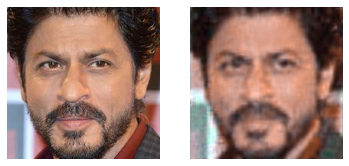

In [271]:
def show_images(tensor1, tensor2):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(tensor1.squeeze().permute(1,2,0))
    axs[0].axis('off')
    axs[1].imshow(tensor2.squeeze().permute(1,2,0))
    axs[1].axis('off')

loaded_model = CompressNet()
loaded_model.load_state_dict(torch.load(PATH))
loaded_model.eval()

x = images_dataset[3].unsqueeze(0).detach()
recon_x = loaded_model(x).detach()

show_images(x, recon_x)

print('Original bound = ', x.min().item(), x.max().item())
print('Recon bound = ', recon_x.min().item(), recon_x.max().item())
print('MSE = ', ((x - recon_x)**2).mean().item())
print('Variance = ', x.var().item(), recon_x.var().item())

-1.2405776977539062
1.3027361631393433
0.5834352970123291
-0.4032820165157318
0.3315194547176361
-0.007410570979118347
-3.116230010986328
-5.018065929412842
0.9737180471420288
-7.018101692199707


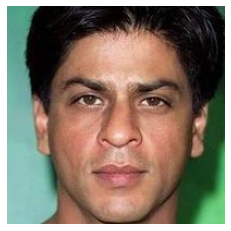

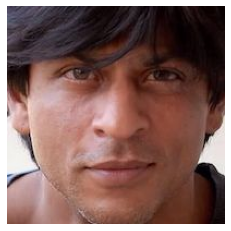

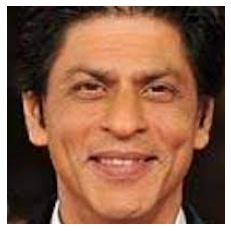

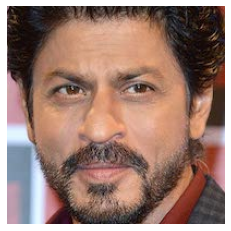

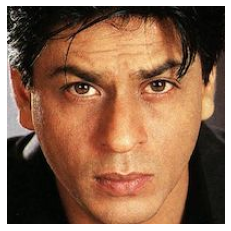

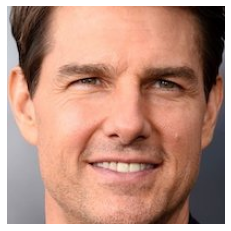

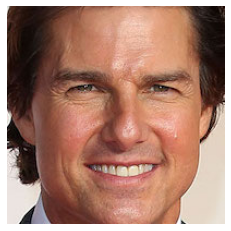

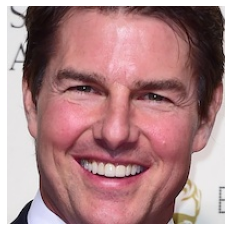

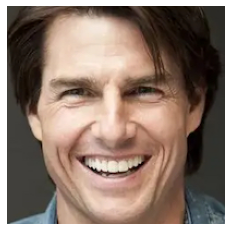

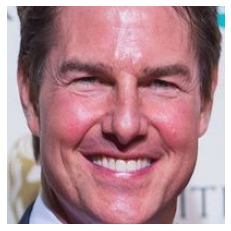

In [303]:
## Print encode values
def show_image(tensor):
    plt.figure()
    plt.imshow(tensor.detach().squeeze().permute(1,2,0))
    plt.axis('off')

for image in images_dataset:
    x = image.unsqueeze(0).detach()
    show_image(x)
    encode = loaded_model.encoder(x)
    print(encode.item())

In [273]:
## Plot encodes on number line
points = []
color = {
    'SRK': 'brown',
    'TC': 'blue'
}
for image in list(images_dataset)[:len(images_dataset) // 2]:
    x = image.unsqueeze(0).detach()
    encode = loaded_model.encoder(x)
    points.append((encode.item(), 'SRK'))

for image in list(images_dataset)[len(images_dataset) // 2:]:
    x = image.unsqueeze(0).detach()
    encode = loaded_model.encoder(x)
    points.append((encode.item(), 'TC'))

fig = go.Figure()
fig.add_trace(go.Scatter(x = [t[0] for t in points], 
                         y = [0] * len(points), 
                         mode = 'markers+text', 
                         text = [t[1] for t in points], textposition='top center',
                         marker_color = [color[t[1]] for t in points]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


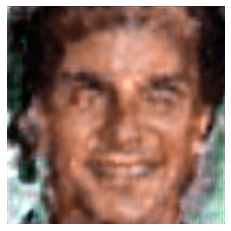

In [306]:
## Produce random images
x1 = -5.018065929412842 + -1.2405776977539062
x2 = -3.116230010986328 + 0.5834352970123291
recon_image = loaded_model.decoder(torch.tensor([[-2.5328]]))
show_image(recon_image)

In [297]:
%%time
## Testing
total_loss = 0.0

with torch.no_grad():
    for data in images_dataloader:
        inputs = data.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        
        total_loss += loss.item()

print(f'Test loss : {total_loss / len(images_dataloader)}')

Test loss : 0.0027502046432346106
CPU times: user 457 ms, sys: 32.1 ms, total: 489 ms
Wall time: 52.4 ms
